In [1]:
# This code is used as a baseline for comparing diffetent types of privacy-preservation techniques.

In [2]:
# ! pip install -r requirements.txt

In [3]:
# Improting the required libraries.
user = "gregor"
node = "mac-m1-max"
from cloudmesh.common.StopWatch import StopWatch
from cloudmesh.common.FlatDict import FlatDict
from cloudmesh.common.util import banner

import tqdm
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from copy import deepcopy

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam

# ours
from approach.lstm_forecast import ShallowForecastLSTM
from util.utils import train_one_step, test_model, predict, SequenceDataset
from util.fed_utils import FedAvg_loop

### Introduction

- Context: time series data, decentralized on "nodes".
- Constraints: the nodes cannot exchange their data.
- Goal: train a predictive model (here forecasting) on each node.

Federated learning: take advantage of the parameters of the models of the other nodes to improve the predictive capacities of each model (local). # FedAvg reference + two-sentence description

### Plan

In [4]:
# performance boxplots

#### 0. Data: time series (one per node)

A time series is a sequence of measurements indexed by time. When at each of these instants of time, a single state variable is measured (e.g. temperature, frequentation of a bus station, etc.), the time series is said to be univariate. A fortiori, when several variables are measured at a given moment, we say that the time series is multivariate (or multivalued).

We note $x_k(t)$ the sample measured on the variable $k$ at time $t$ for $k = 1 \dots K$ and $t = 0, \dots T$.

Often, when we study a multivariate time series, we conjecture that the variables $K$ (or a subset) are correlated with each other over time, that is to say that the variables $x_{k_1}$ and $x_{k_2}$ evolve together. In this case, it assumes that to predict the future value $x_{k_1}(T+1)$ (unmeasured) from its past values $x_{k_1}(t=0) \dots x_{k_1}( t=T)$, we must also consider the passed values $x_{k_2}(t=0) \dots x_{k_2}(t=T)$.

#### 1. The prediction model (forecasting)

Here, we want to train a model to predict the future values of each of the variables (forecasting), i.e. give an estimate of $x_{1}(T+1), \dots x_{k}(T +1) \dots x_{K}(T+1)$. Each model $k$ (a Long Short Term Memory type neural network) will then attempt to approximate a function $f_k$ such that $x_{t+1} = f_k (x_t, \dots x_{t-1} \ dots )$. The prediction function $f_k$ represents the model $k$ and has, say $p$ parameters $w_{1,k}, \dots w_{1,p}$.

#### 2. Federated learning context

In our context, we assume that the data of a variable $k$ are measured on a node $k$. This data cannot be communicated and shared with other nodes. It is therefore impossible to build a global model from the data of all the variables. We will therefore train one model per node. In order to take these possible correlations into consideration, each model can be trained by sharing not the data but the parameters of each model with a central server. A simple strategy, called Federated Averaging, consists of averaging the parameters of each of the models, more concretely:
- (1.) the local model $k$ learns on its data $x_{k}(t=0) \dots x_{k}(t=T)$,
- (2.) the model $k$ sends its parameters, say $w_{1,k}, \dots w_{p,k}$ to the central server,
- (3.) the central server calculates the average $w_{1}^c, \dots w_{p}^c$ of the $p$ parameters of the $K$ models: e.g. for a parameter $w_{p}^c = \frac{1}{K} \sum_{i=1}^{K} w_{p,i}$,
- (4.) the central server returns the averaged parameters to node $k$,
- (5.) the local model $k$ receives the parameters $w_{1}^c, \dots w_{p}^c$, and starts again at step (1.).

Bibliographic reference of the Federated Averaging algorithm: H. B. McMahan, E. Moore, D. Ramage, S. Hampson, and B. Agüera y Arcas, “Communication-Efﬁcient Learning of Deep Networks from Decentralized Data,” in AISTATS, 2017, vol. 54.

### Purpose of the notebook:
- apply Federated Averaging to predict over time (forecaster) on each node,
- compare to non-federated learning (the nodes do not communicate with each other),
- compare to "classical" centralized learning, where the data for each of the variables is not distributed and is used to train a single model on a "big" multivariate time series.

### Application and comparison

Here it is assumed that each node contains data from a single time series.

In [5]:
StopWatch.start("total")
StopWatch.start("load-data")
config = FlatDict()
config.load("config.yaml")

x_data = np.load("./datasets/electricity.npy")
T_size, p = x_data.shape # output is (10560, 963)
n_clients = int(config["experiment.clients"]) # 50 # reduced number for the example
t_grid = np.arange(0, T_size) # output is array([    0,     1,     2, ..., 10557, 10558, 10559])

# common to all experiments
T_train = int(0.70 * T_size) # output is 7391
lag = 40 # number of time-consecutive samples within a mini batch

type load


In [6]:
tmp = pd.DataFrame(x_data)
StopWatch.stop("load-data")

banner("config.yaml")
print(config)

banner("X DATA")

tmp


# ----------------------------------------------------------------------
# config.yaml
# ----------------------------------------------------------------------

{'experiment.epoch': 20, 'experiment.batch_size': 8, 'experiment.clients': 5, 'experiment.learning_rate': '1e-2', 'experiment.weight_decay': '1e-2', 'experiment.patience': 5, 'sep': '.'}

# ----------------------------------------------------------------------
# X DATA
# ----------------------------------------------------------------------



,0,1,2,3,4,5,6,7,8,9,...,360,361,362,363,364,365,366,367,368,369
0,16.497462,91.038407,309.296264,552.845528,289.024390,1392.857143,34.482759,1117.845118,291.958042,351.612903,...,482.512491,103900.0,6042.194093,6636.363636,62.581486,51.492101,2096.575944,243.739566,2854.105572,0.000000
1,19.035533,92.460882,309.296264,548.780488,280.487805,1357.142857,27.699265,1104.377104,269.230769,329.032258,...,451.106353,95500.0,4388.185654,6613.636364,63.885267,42.129901,2200.175593,245.409015,2823.313783,0.000000
2,16.497462,91.749644,309.296264,546.747967,265.853659,1145.833333,26.568683,959.595960,255.244755,288.172043,...,410.421128,96600.0,4278.481013,6568.181818,63.885267,38.619075,1996.488147,203.672788,2756.598240,0.000000
3,19.035533,88.193457,309.296264,408.536585,201.219512,767.857143,19.219898,801.346801,166.083916,184.946237,...,259.814418,93400.0,4168.776371,6318.181818,73.011734,38.619075,1320.456541,188.647746,2724.340176,0.000000
4,17.766497,87.482219,309.296264,327.235772,180.487805,622.023810,14.132278,720.538721,183.566434,169.892473,...,295.503212,90300.0,4130.801688,6272.727273,62.581486,35.108250,1314.310799,190.317195,2741.202346,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,7.614213,110.241821,6.950478,821.138211,385.365854,1532.738095,47.484454,1380.471380,412.587413,343.010753,...,1501.784440,163700.0,8776.371308,9568.181818,284.224250,19.894675,1840.210711,160.267112,2764.662757,34918.918919
26300,8.883249,97.439545,6.950478,713.414634,359.756098,1324.404762,45.223290,1188.552189,351.398601,313.978495,...,1317.630264,157900.0,6586.497890,8340.909091,298.565841,16.383850,1357.330992,525.876461,2722.873900,32864.864865
26301,10.152284,90.327169,6.950478,650.406504,351.219512,1267.857143,46.353872,1074.074074,293.706294,276.344086,...,1309.064954,154200.0,6590.717300,5704.545455,294.654498,17.554125,2047.410009,661.101836,2647.360704,33189.189189
26302,8.883249,88.193457,6.950478,630.081301,339.024390,1247.023810,45.223290,1026.936027,283.216783,292.473118,...,1178.443969,133100.0,6514.767932,5454.545455,220.338983,30.427150,2796.312555,784.641068,2709.677419,30108.108108


In [7]:
n_epoch = int(config["experiment.epoch"]) # 100
batch_size = int(config["experiment.batch_size"]) # 2**3

Graphs of the data of some nodes $x_0 \dots x_{15}$ as a function of time.

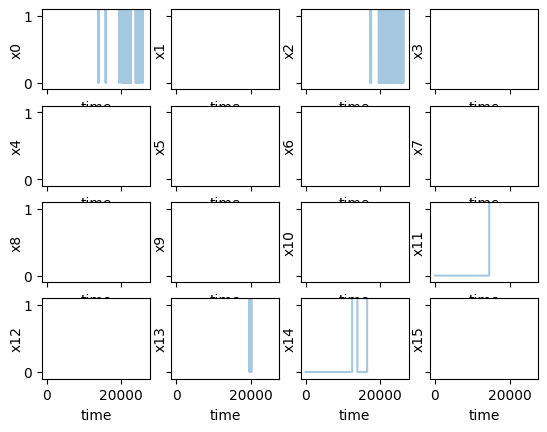

In [8]:
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True)
axs = axs.ravel()

axs[0].set_ylim((-0.1, 1.1))
for k in range(16): # 16 clients (nodes)
    axs[k].plot(
        t_grid, x_data[:, k],
        alpha=0.4
        )
    axs[k].set_ylabel(f'x{k}', labelpad=-0.5)
    axs[k].set_xlabel('time')

In [9]:
x_data[:, 2]

array([309.29626412, 309.29626412, 309.29626412, ...,   6.95047785,
         6.95047785,   6.95047785])

In [10]:
x_data[:T_train, 1].shape

(18412,)

In [11]:
x_data[T_train:, 1].shape

(7892,)

In [12]:
# Contents

#### I. NON-federated workouts

Objective: for each indexed variable $k$, $x_1 \dots x_{K}$, we want to train a model that predicts $x_k(t+1)$ according to its past values $x_k(t), x_k(t-1 ), \dots$

Here we train one model per node, independently of the (data and models) of the other nodes.

We start by creating one dataset per variable (which is naturally the case in a federated context). Each dataset is then divided into two sets training/testing then centered-reduced.

In [13]:
StopWatch.start("non-federated-workouts")
train_loaders, test_loaders = [], []

# one scaler for each node
scalers =  [StandardScaler(with_mean=True, with_std=True) for k in range(n_clients)]

for k in range(n_clients):
    
    train_loaders.append(
        DataLoader(
            SequenceDataset(
                scalers[k].fit_transform(x_data[:T_train, k][:, np.newaxis]), # center-reduce train data of client k
                lag=lag
            ),
            batch_size=batch_size, shuffle=True
        )
    )

    test_loaders.append(
        DataLoader(
            SequenceDataset(
                scalers[k].transform(x_data[T_train:, k][:, np.newaxis]),
                lag=lag
            ),
            batch_size=batch_size, shuffle=False # makes the data same when batches are requested at different times
        )
    )
StopWatch.stop("non-federated-workouts")

We choose a one-layer Long Short Time Memory (LSTM) recurrent neural network model with a small number of neurons (for the example). Each node will have the same model architecture but will be trained on its own data only.

In [14]:
# desgin the model
StopWatch.start("design-model")
num_hidden_units = 5 # 50
models_nofed = [ShallowForecastLSTM(num_var=1, hidden_units=num_hidden_units) for k in range(n_clients)]
StopWatch.stop("design-model")


Finally, we fix the training procedure which itself involves the choice of an error function to minimize, a minimizer, a learning step, etc.

In [15]:
# train the models
StopWatch.start("train-model")
loss_function = nn.MSELoss()
learning_rate = float(config["experiment.learning_rate"])

optimizers = [Adam(
    models_nofed[k].parameters(),
    lr=learning_rate,
    betas=(0.60, 0.75),
    weight_decay=float(config["experiment.weight_decay"])
) for k in range(n_clients)]

# self-tuning of the learning step at each iteration on each client
schedulers = [ReduceLROnPlateau(optimizers[k], 'min', patience = 7) for k in range(n_clients)]

# 
train_loss_epoch = np.empty((n_epoch, n_clients))
test_loss_epoch = np.empty_like(train_loss_epoch)

# for each client
loop = tqdm(n_clients * n_epoch)
for k in range(n_clients):
    print(f'==Learning model of node#{k}==')

    # for each learning step
    for i_epoch in range(n_epoch):
        print(f'------\n Node {k} Epoch {i_epoch}')

        # train
        train_loss_epoch[i_epoch, k], model_k = train_one_step(
            train_loaders[k], models_nofed[k], loss_function, optimizer=optimizers[k]
            )

        # test
        test_loss_epoch[i_epoch, k] = test_model(
            test_loaders[k], models_nofed[k], loss_function, verbose=True)

        # learning rate decay
        schedulers[k].step(test_loss_epoch[i_epoch, k])
        
        if i_epoch == n_epoch - 1:
            models_nofed[k] = deepcopy(models_nofed[k])
        loop.set_description(f"Node [{k}/{n_clients}] Epoch [{i_epoch}/{n_epoch}]")
        loop.set_postfix(loss=test_loss_epoch[i_epoch, k]) # , acc.rand(1).item())
StopWatch.stop("train-model")

==Learning model of node#0==
------
 Epoch 0
Train loss: 0.2508972170025387
Test loss: 0.1371483404203856
------
 Epoch 1
Train loss: 0.23778254111911568
Test loss: 0.1344354326285119
------
 Epoch 2
Train loss: 0.23672338997514625
Test loss: 0.12836218383294137
------
 Epoch 3
Train loss: 0.23538684822087153
Test loss: 0.13434267920368384
------
 Epoch 4
Train loss: 0.23684220431653902
Test loss: 0.12542787033022101
------
 Epoch 5
Train loss: 0.23302121821527558
Test loss: 0.1271883953251124
------
 Epoch 6
Train loss: 0.23392685269517177
Test loss: 0.12590849877187932
------
 Epoch 7
Train loss: 0.2340860389513174
Test loss: 0.13762204597458544
------
 Epoch 8
Train loss: 0.23444645443299483
Test loss: 0.12547550472433716
------
 Epoch 9
Train loss: 0.23327641797886772
Test loss: 0.12479593923945606
------
 Epoch 10
Train loss: 0.23491637907468338
Test loss: 0.12636554248758622
------
 Epoch 11
Train loss: 0.23375137488114575
Test loss: 0.13164112714058865
------
 Epoch 12
Train los

In [16]:
# average testing loss (across clients) along the iterations
print('Global testing loss')
StopWatch.start("train-loss")
np.average(test_loss_epoch, axis=1, weights=np.ones(n_clients))
StopWatch.stop("train-loss")

Global testing loss


Visualization of training/test errors per node.

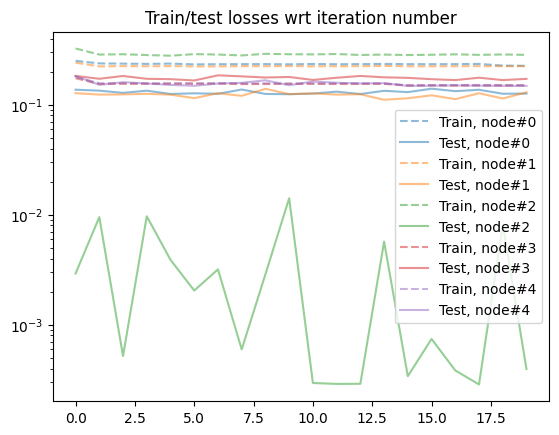

In [17]:
for k in range(n_clients):
    # make a function
    plt.plot(train_loss_epoch[:, k], label=f'Train, node#{k}', color=f'C{k}', alpha=0.5, linestyle='dashed')
    plt.plot(test_loss_epoch[:, k], label=f'Test, node#{k}', color=f'C{k}', alpha=0.5, linestyle='solid')

plt.title('Train/test losses wrt iteration number')
plt.yscale('log')
plt.legend()
plt.show()

Visualization of predictions/true values on training/test sets.

In [18]:
t_train, t_test = np.arange(0, T_train), np.arange(T_train, T_size)

In [19]:
def plot_client_pred_truth(idx_client, models, train_samples=True, timesteps=t_train):
    """plot samples vs predictions"""

    # compute prediction
    if train_samples:
        x_pred = scalers[k].inverse_transform(predict(train_loaders[k], models[k]).numpy())
    else:
        x_pred = scalers[k].inverse_transform(predict(test_loaders[k], models[k]).numpy())

    # plot the time series
    if train_samples:
        plt.plot(timesteps, x_data[:T_train, idx_client], marker='o', label='Truth', color='C0', alpha=0.25)
    else:
        plt.plot(timesteps, x_data[T_train:, idx_client], label='Truth',  marker='o', color='C0', alpha=0.25)

    plt.plot(timesteps, x_pred, label='Prediction', color='red', alpha=0.25)
    plt.legend(); plt.show()

Graph of the time series (test data) of the customer $k$ and the associated predictions of the model $k$.

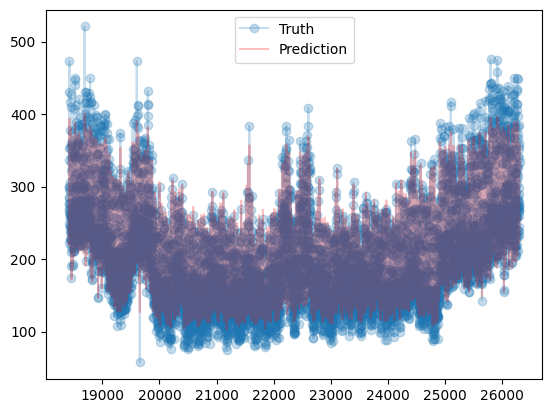

In [20]:
plot_client_pred_truth(
    idx_client=4,
    models=models_nofed,
    train_samples=False,
    timesteps=t_test
    )

### II. Federated training

Objective: for each indexed variable $k$, $x_1 \dots x_{K}$, we want to train a model that predicts $x_k(t+1)$ according to its past values $x_k(t), x_k(t-1 ), \dots$ in the federated context. The local models (nodes) are first trained independently of each other (as in I.), then they share their model (weight of the LSTM) with the central server (federator) which itself aggregates the models (weight $\ textit of $LSTM). This aggregated model is returned to each client that iterates training locally.

This iterative process, called “communication round”, between the local nodes and the central server, can be repeated several times (n_cr times).
n_cr: number of communication rounds.

In [21]:
StopWatch.start("federated-learning")
models_fed, local_losses_bfr_fedavg, local_losses_aft_fedavg, global_loss  = FedAvg_loop(
    call_basemodel=ShallowForecastLSTM,
    archi_basemodel={'n_inputs': 1, 'n_hidden': 10},
    train_sets=train_loaders,
    test_sets=test_loaders,
    n_cr=5, n_local_epochs=n_epoch,
    lr= 10**-2
)
StopWatch.stop("federated-learning")

Communication round 0
-------------------
**Learning client#0
--------------
Train loss: 0.2750113878303453
Train loss: 0.23389337558951573
Train loss: 0.23097117820843754
Train loss: 0.22876508766168294
Train loss: 0.2271874839497943
Train loss: 0.225031822462301
Train loss: 0.22297894717521843
Train loss: 0.22144657434237902
Train loss: 0.22004645724174404
Train loss: 0.21881757088680012
Train loss: 0.21796338667817067
Train loss: 0.21742230518207492
Train loss: 0.21685838060212106
Train loss: 0.21608259678976272
Train loss: 0.21581151878045948
Train loss: 0.2158505911912549
Train loss: 0.2147287904874506
Train loss: 0.21483175099806007
Train loss: 0.21460651339519365
Train loss: 0.21454860054786487
**Client test loss before FedAvg 0.9135632346315345
**Client test loss after FedAvg 0.12083412241662467

--------------
**Learning client#1
--------------
Train loss: 0.3529171151704568
Train loss: 0.21688382807337428
Train loss: 0.20692389511831386
Train loss: 0.20167975475183073
Train l

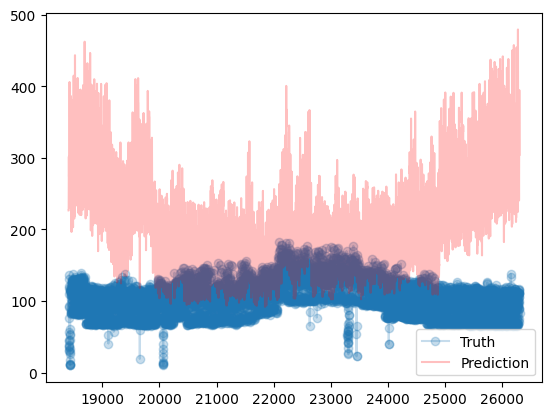

In [22]:
plot_client_pred_truth(
    idx_client=1,
    models=models_fed,
    train_samples=False,
    timesteps=t_test
    )

### III. Central drive

Here, we leave the decentralized context, where we train one model per node. This time, we are in the classic case: the data form a complete centralized dataset. A model is trained from this complete dataset (all data).

In this context, correlations between variables $k=1 \dots K$ influence the learned model. It is important to understand that in stages I. and II. these correlations are ignored by construction (consequently the models of stages I. and II. are based only on the observed values of each of the variables).

In [23]:
# scale the data
## one scaler for the whole dataset as we only have a centralized one
scaler =  StandardScaler(with_mean=True, with_std=True)

train_dataset = SequenceDataset(
    scaler.fit_transform(x_data[:T_train, :n_clients]), lag=lag
    )
test_dataset = SequenceDataset(
    scaler.transform(x_data[T_train:, :n_clients]), lag=lag
    )

batch_size = int(config["experiment.batch_size"])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
num_hidden_units = 5 #50
model_cent = ShallowForecastLSTM(num_var=n_clients, hidden_units=num_hidden_units)

In [25]:
# train the model
StopWatch.start("train-model-central-drive")
loss_function = nn.MSELoss()
learning_rate = float(config["experiment.learning_rate"])
optimizer = Adam(model_cent.parameters(), lr=learning_rate, betas=(0.6, 0.75))
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = int(config["experiment.patience"]))

print("Untrained test\n--------")
test_model(test_loader, model_cent, loss_function)

train_loss_epoch = np.empty(n_epoch)
test_loss_epoch = np.empty(n_epoch)

for i_epoch in range(n_epoch):
    print(f"Epoch {i_epoch}\n---------")

    train_loss_epoch[i_epoch] = train_one_step(
        train_loader, model_cent, loss_function, optimizer=optimizer
        )[0]
    test_loss_epoch[i_epoch] = test_model(test_loader, model_cent, loss_function)
    scheduler.step(test_loss_epoch[i_epoch])
StopWatch.stop("train-model-central-drive")


Untrained test
--------
Test loss: 0.8379805570557004
Epoch 0
---------
Train loss: 0.26331408769151216
Test loss: 0.11439030431399713
Epoch 1
---------
Train loss: 0.2037268137230783
Test loss: 0.11654973300900442
Epoch 2
---------
Train loss: 0.19931352272675049
Test loss: 0.11606222904441084
Epoch 3
---------
Train loss: 0.19533236866103215
Test loss: 0.11942476528793905
Epoch 4
---------
Train loss: 0.19185297951129768
Test loss: 0.11752224818868477
Epoch 5
---------
Train loss: 0.1918625178068009
Test loss: 0.11556586130260817
Epoch 6
---------
Train loss: 0.19106356957466136
Test loss: 0.11653303138330473
Epoch 7
---------
Train loss: 0.1822368880907004
Test loss: 0.11027061701549373
Epoch 8
---------
Train loss: 0.18100199162260955
Test loss: 0.10961940044040859
Epoch 9
---------
Train loss: 0.1810784674873438
Test loss: 0.11124762064346094
Epoch 10
---------
Train loss: 0.18100407620734954
Test loss: 0.10922140231414527
Epoch 11
---------
Train loss: 0.1808457104003722
Test los

In [26]:
StopWatch.stop("total")
StopWatch.benchmark(user=user, node=node)


+------------------+-------------------------------------------------------------------------------------------------------+
| Attribute        | Value                                                                                                 |
|------------------+-------------------------------------------------------------------------------------------------------|
| cpu              | Apple M1 Max                                                                                          |
| cpu_cores        | 10                                                                                                    |
| cpu_count        | 10                                                                                                    |
| cpu_threads      | 10                                                                                                    |
| date             | 2023-07-23 18:44:32.978107                                                                            |